In [16]:
cd /content/drive/My Drive/Colab Notebooks/PRACTICE Learning/Coursera_Tensorflow/Sign_gesture

/content/drive/My Drive/Colab Notebooks/PRACTICE Learning/Coursera_Tensorflow/Sign_gesture


In [17]:
ls

Signs_Classification  test_signs.h5  train_signs.h5


In [0]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math

#**Defining Helping Functions**

In [0]:
def load_dataset():
  train_dataset = h5py.File("train_signs.h5", "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:])
  train_set_y_orig = np.array(train_dataset["train_set_y"][:])

  test_dataset = h5py.File("test_signs.h5", "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:])
  test_set_y_orig = np.array(test_dataset["test_set_y"][:])

  classes = np.array(test_dataset["list_classes"][:])

  train_set_y_orig = train_set_y_orig.reshape((1,train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1,test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
def random_mini_batches(X,Y,minibatch_size = 64, seed = 0):
  m = X.shape[1]
  mini_batches = []
  np.random.seed(1)

  #step 1: Shuffling the dataset
  permutation = list(np.random.permutation(m))
  shuffled_X = X[:,permutation]
  shuffled_Y = Y[:,permutation]
  #step 2: Creating the mini batches
  num_complete_minibatches = math.floor(m/minibatch_size)
  for k in range(num_complete_minibatches):
    mini_batch_X = shuffled_X[:, k*num_complete_minibatches:(k+1)*num_complete_minibatches]
    mini_batch_Y = shuffled_Y[:, k*num_complete_minibatches:(k+1)*num_complete_minibatches]
    mini_batch = (mini_batch_X,mini_batch_Y)
    mini_batches.append(mini_batch)

  if m % minibatch_size != 0:
    mini_batch_X = shuffled_X[:, num_complete_minibatches*minibatch_size:m]
    mini_batch_Y = shuffled_Y[:, num_complete_minibatches*minibatch_size:m]
    mini_batch = (mini_batch_X,mini_batch_Y)
    mini_batches.append(mini_batch)

  return mini_batches
  

In [0]:
def convert_to_one_hot(Y, C):
  Y = np.eye(C)[Y.reshape(-1)].T
  return Y

In [0]:
def create_placeholders(n_x,n_y):
  X = tf.placeholder(tf.float32, shape=[n_x,None])
  Y = tf.placeholder(tf.float32, shape=[n_y,None])
  return X, Y

In [0]:
def initialize_parameters():
  tf.set_random_seed(1)

  W1 = tf.get_variable("W1",[25,12288],initializer= tf.contrib.layers.xavier_initializer(seed=1))
  b1 = tf.get_variable("b1",[25,1],initializer= tf.zeros_initializer())
  W2 = tf.get_variable("W2",[25,25],initializer= tf.contrib.layers.xavier_initializer(seed = 1))
  b2 = tf.get_variable("b2",[25,1],initializer= tf.zeros_initializer())
  W3 = tf.get_variable("W3",[12,25],initializer= tf.contrib.layers.xavier_initializer(seed=1))
  b3 = tf.get_variable("b3",[12,1],initializer= tf.zeros_initializer())
  W4 = tf.get_variable("W4",[6,12],initializer= tf.contrib.layers.xavier_initializer(seed=1))
  b4 = tf.get_variable("b4",[6,1],initializer= tf.zeros_initializer())


  parameters = {"W1":W1,
                "b1":b1,
                "W2":W2,
                "b2":b2,
                "W3":W3,
                "b3":b3,
                "W4":W4,
                "b4":b4}
  return parameters


In [0]:
def forward_propagation(X, parameters):

  #retrieving the parameters
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]
  W3 = parameters["W3"]
  b3 = parameters["b3"]
  W4 = parameters["W4"]
  b4 = parameters["b4"]

  #Linear Forward With Activation
  Z_1 = tf.add(tf.matmul(W1,X),b1)
  Z1 = tf.nn.dropout(Z_1, rate = 0)
  A1 = tf.nn.relu(Z1)
  Z_2 = tf.add(tf.matmul(W2,A1),b2)
  Z2 = tf.nn.dropout(Z_2, rate= 0)
  A2 = tf.nn.relu(Z2)
  Z_3 = tf.add(tf.matmul(W3,A2),b3)
  Z3 = tf.nn.dropout(Z_3, rate= 0)
  A3 = tf.nn.relu(Z3)
  Z4 = tf.add(tf.matmul(W4,A3),b4)

  return Z4

In [0]:
def compute_cost(Z4,Y):

  logits = tf.transpose(Z4)
  labels = tf.transpose(Y)
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits= logits, labels = labels))

  return cost

In [0]:
def model(X_train,Y_train,X_test,Y_test, learning_rate = 0.00001, num_epochs = 2000, minibatch_size = 32, print_cost = True):
  tf.reset_default_graph()
  tf.set_random_seed(1)
  seed = 3
  lambd = 0.3

  (n_x,m) = X_train.shape
  n_y = Y_train.shape[0]
  costs = []

  X,Y = create_placeholders(n_x,n_y)
  parameters = initialize_parameters()
  W1,W2,W3,W4 = parameters["W1"],parameters["W2"],parameters["W3"],parameters["W4"]
  Z4 = forward_propagation(X,parameters)
  loss = compute_cost(Z4,Y)
  regularizer = tf.nn.l2_loss(W1)+tf.nn.l2_loss(W2)+tf.nn.l2_loss(W3)+tf.nn.l2_loss(W4)
  cost = tf.reduce_mean(loss + (lambd/m)*regularizer)
  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

  init = tf.global_variables_initializer()

  with tf.Session() as sess:
    sess.run(init)
    for i in range(num_epochs):
      
      epoch_cost = 0
      num_minibatches = int(m/minibatch_size)
      seed = seed+1
      minibatches = random_mini_batches(X_train,Y_train, minibatch_size, seed)

      for minibatch in minibatches:
        (minibatch_X,minibatch_Y) = minibatch
        _,minibatch_cost = sess.run([optimizer,cost], feed_dict = {X:minibatch_X,Y:minibatch_Y})
        epoch_cost += minibatch_cost/minibatch_size

      if print_cost and i%100 == 0:
        print("Cost after epoch %i: %f" %(i,epoch_cost))
      if print_cost and i%5==0:
        costs.append(epoch_cost)

    plt.plot(np.squeeze(costs))
    plt.xlabel("Iterartions(per 5)")
    plt.ylabel("Cost")
    plt.title("Learning Rate:"+str(learning_rate))
    plt.show()


    parameters = sess.run(parameters)
    correct_prediction = tf.equal(tf.argmax(Z4), tf.argmax(Y))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))

    print("Train Acccuracy:",accuracy.eval({X: X_train,Y: Y_train}))
    print("Test Acccuracy:",accuracy.eval({X: X_test,Y: Y_test}))

    return parameters

In [0]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_dataset()

[3]


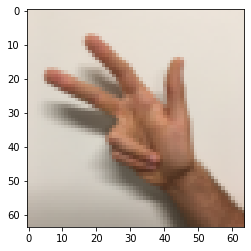

In [60]:
plt.imshow(train_set_x_orig[25])
print((train_set_y_orig[:,25]))

In [0]:
X_train_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
X_test_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

X_train = X_train_flatten/255
X_test = X_test_flatten/255

Y_train = convert_to_one_hot(train_set_y_orig,6)
Y_test = convert_to_one_hot(test_set_y_orig,6)

Cost after epoch 0: 1.916149
Cost after epoch 100: 1.584626
Cost after epoch 200: 1.399865
Cost after epoch 300: 1.231425
Cost after epoch 400: 1.087362
Cost after epoch 500: 0.959258
Cost after epoch 600: 0.843798
Cost after epoch 700: 0.743908
Cost after epoch 800: 0.653831
Cost after epoch 900: 0.577303
Cost after epoch 1000: 0.510606
Cost after epoch 1100: 0.451263
Cost after epoch 1200: 0.397893
Cost after epoch 1300: 0.350212
Cost after epoch 1400: 0.307866
Cost after epoch 1500: 0.269958
Cost after epoch 1600: 0.235834
Cost after epoch 1700: 0.205679
Cost after epoch 1800: 0.179708
Cost after epoch 1900: 0.156266


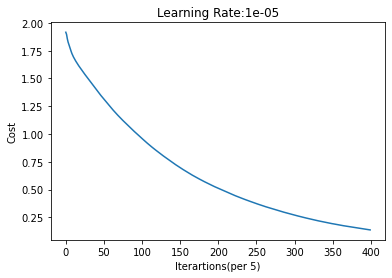

Train Acccuracy: 0.9787037
Test Acccuracy: 0.85


In [90]:
parameters = model(X_train,Y_train,X_test,Y_test)

#**Prediction**

In [0]:
def predict(X, parameters):
    
    
    
    x = tf.placeholder("float", [12288, None])
    
    z4 = forward_propagation(x, parameters)
    p = tf.argmax(z4)
    
    with tf.Session() as sess:
        prediction = sess.run(p, feed_dict = {x: X})
          
    return prediction
    

In [0]:
Y_pred = predict(X_test,parameters)

In [143]:
Y_pred.reshape((1,120)) 

array([[1, 0, 0, 5, 1, 0, 3, 1, 4, 1, 5, 1, 3, 1, 1, 3, 5, 4, 0, 4, 5, 2,
        2, 5, 3, 5, 4, 2, 1, 4, 3, 1, 0, 3, 1, 1, 0, 2, 2, 3, 0, 3, 0, 2,
        3, 1, 1, 3, 0, 3, 4, 1, 2, 0, 4, 0, 4, 0, 2, 5, 5, 4, 2, 4, 4, 3,
        0, 1, 3, 5, 0, 5, 3, 1, 3, 4, 3, 5, 1, 5, 2, 0, 1, 3, 2, 4, 4, 1,
        4, 5, 5, 0, 0, 4, 5, 5, 3, 3, 4, 2, 2, 2, 0, 3, 5, 3, 0, 2, 3, 4,
        1, 3, 2, 4, 2, 2, 1, 3, 1, 3]])

The sign says: 0


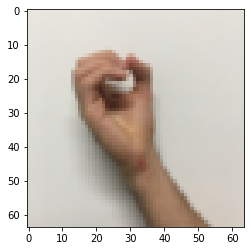

In [151]:
index = 70
plt.imshow(test_set_x_orig[index])
print("The sign says:",Y_pred[index])